In [1]:
from ultralytics import YOLO
import os
import yaml
from IPython.display import Image
import json
import cv2
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import torch
import pandas as pd
import random
import easyocr
import matplotlib.pyplot as plt
from pathlib import Path

In [ ]:
project_dir = os.path.dirname(os.getcwd())
dataset_location = os.path.join(project_dir, 'data', 'ocr_evaluation')
training_name = 'experiment2'
log_dir = os.path.join(project_dir, 'data', 'roboflow_dataset_yolo_v11', 'logs')
model_weights_location = f'{log_dir}/{training_name}/weights/best.pt'

output_location = os.path.join(project_dir, 'data', 'yolo_v11')


In [3]:
model = YOLO(model_weights_location)

# Specify the directory containing images to detect objects on
images_dir = dataset_location  # replace with the path to your dataset
output_log_dir = f'{output_location}/detection_results/labels'  # directory to save detection info
output_img_dir = f'{output_location}/detection_results'
cropped_plates_path = f'{output_location}/cropped_plates'

Path(output_log_dir).mkdir(parents=True, exist_ok=True)
Path(output_img_dir).mkdir(parents=True, exist_ok=True)
Path(cropped_plates_path).mkdir(parents=True, exist_ok=True)

In [ ]:
# Run inference and save details
for image_path in Path(images_dir).glob("*.jpg"):  # replace with the appropriate extension if different
    # Perform detection
    results = model(image_path)
    
    # Prepare to save results
    detections = []
    # Process results list
    # for result in results:
    #     boxes = result.boxes  # Boxes object for bounding box outputs
    #     masks = result.masks  # Masks object for segmentation masks outputs
    #     keypoints = result.keypoints  # Keypoints object for pose outputs
    #     probs = result.probs  # Probs object for classification outputs
    #     obb = result.obb  # Oriented boxes object for OBB outputs
    #     result.show()  # display to screen
    #     result.save(filename="result.jpg")  # save to disk
    max_conf = -1.0
    for det in results[0].boxes.data:  # detections for the image
        conf = float(det[4])
        if conf < max_conf:
            continue
        else:
            max_conf = conf
        x1, y1, x2, y2, conf, cls = map(float, det[:6])
        # class_name = model.names[int(cls)]
        detections.append({
            "x1": x1,
            "y1": y1,
            "x2": x2,
            "y2": y2,
            "confidence": conf,
            "class": int(cls)
        })
    
    if max_conf == -1:
        continue

    img = cv2.imread(image_path)
    cropped_plate = img[int(y1):int(y2), int(x1):int(x2)]
    plate_save_path = os.path.join(cropped_plates_path, f'plate_{image_path.stem}.jpg')
    cv2.imwrite(plate_save_path, cropped_plate)

    results[0].save(filename=f'{output_img_dir}/{image_path.stem}.jpg')
    
    # Save detections to a JSON file
    output_file = Path(output_log_dir) / f"{image_path.stem}_detections.json"
    with open(output_file, 'w') as f:
        json.dump(detections, f, indent=4)



image 1/1 /home/roma/5sem/Real-time_Number_Plate_Recognition/data/ocr_evaluation/00298.jpg: 480x640 1 License_Plate, 8.8ms
Speed: 2.3ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/roma/5sem/Real-time_Number_Plate_Recognition/data/ocr_evaluation/00765.jpg: 480x640 1 License_Plate, 8.3ms
Speed: 2.3ms preprocess, 8.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/roma/5sem/Real-time_Number_Plate_Recognition/data/ocr_evaluation/01508.jpg: 448x640 1 License_Plate, 8.7ms
Speed: 1.8ms preprocess, 8.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/roma/5sem/Real-time_Number_Plate_Recognition/data/ocr_evaluation/01348.jpg: 448x640 1 License_Plate, 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/roma/5sem/Real-time_Number_Plate_Recognition/data/ocr_evaluation/00844.jpg: 480x640 1 License_Plate, 8.

In [4]:
reader = easyocr.Reader(['en'])

In [5]:
source_dataset_location = dataset_location
cropped_dataset_location = cropped_plates_path
results_dir = f"{output_location}/ocr_results"
scale_dataset_location = f"{output_location}/scaled_plates"

In [7]:
os.makedirs(results_dir, exist_ok=True)
os.makedirs(scale_dataset_location, exist_ok=True)

for img_file in os.listdir(cropped_dataset_location):
    if img_file.endswith('jpg'):
        img_path = os.path.join(cropped_dataset_location, img_file)

        img = cv2.imread(img_path)

        scale_factor = 2
        img = cv2.resize(img, (0, 0), fx=scale_factor, fy=scale_factor)
        img = cv2.GaussianBlur(img,(5,5),0)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        output_path = os.path.join(scale_dataset_location, img_file)
        cv2.imwrite(output_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

        result = reader.readtext(output_path)
    
        output_txt_path = os.path.join(results_dir, img_file[:-3]+'json')
        with open(output_txt_path, 'w') as f:
            dict_lst = []
            for (bbox, text, prob) in result:
                dict_lst.append({'Text' : text, 'Probability' : prob})
            json.dump(dict_lst, f)


{'Text': '72', 'Probability': 0.6985039031525284}
{'Text': '1', 'Probability': 0.98191631813879}
{'Text': 'LVL', 'Probability': 0.986236297258431}


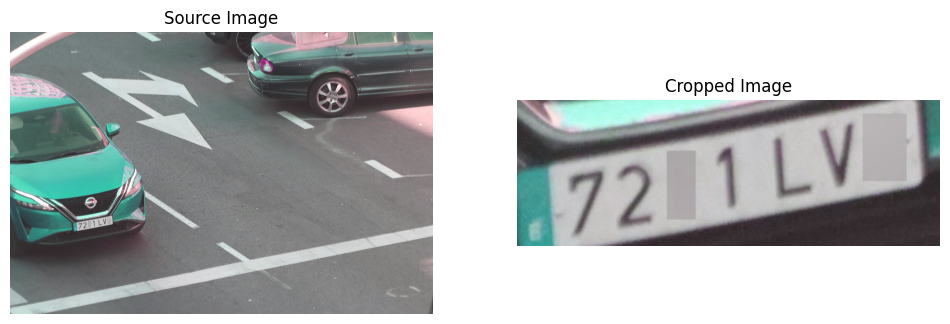

{'Text': '3', 'Probability': 0.05129762825134088}
{'Text': '399', 'Probability': 0.9999977975838318}
{'Text': 'D', 'Probability': 0.47310277184596217}


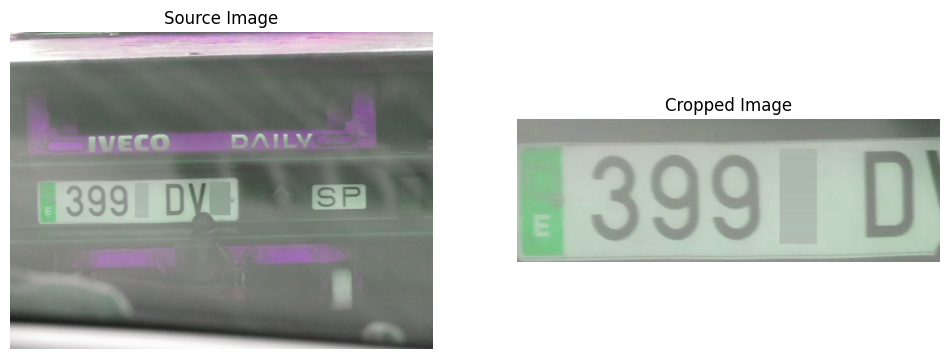

{'Text': '5600', 'Probability': 0.8017329573631287}
{'Text': 'LV', 'Probability': 0.9959484713404532}


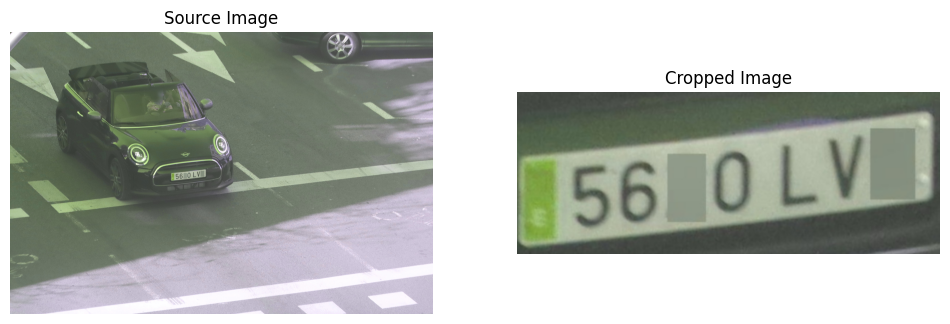

{'Text': '37L', 'Probability': 0.7611340880393982}
{'Text': 'FX', 'Probability': 0.9941334069731005}


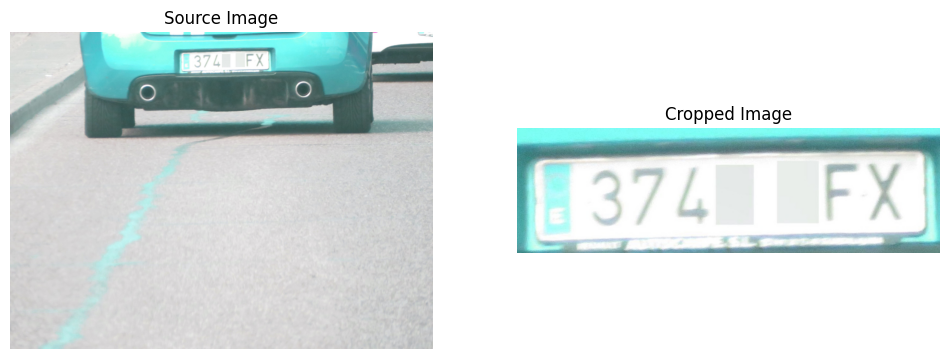

{'Text': '68', 'Probability': 0.9996084782298202}
{'Text': 'M', 'Probability': 0.008485538325765596}
{'Text': 'Ee', 'Probability': 0.0018559972891611725}


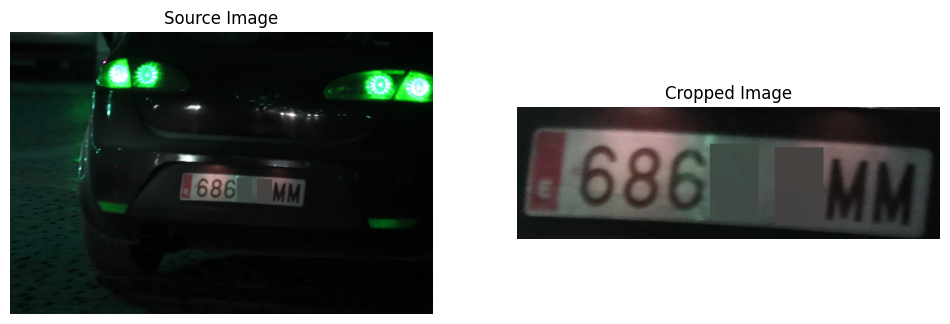

{'Text': '6', 'Probability': 0.2789706527374314}
{'Text': '7', 'Probability': 0.10136728448696974}
{'Text': '21', 'Probability': 0.7248230343291412}
{'Text': 'A', 'Probability': 0.0034374669467693852}


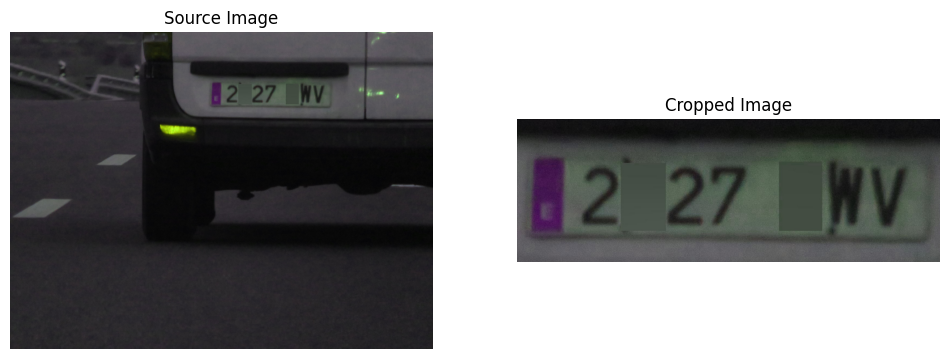

{'Text': '6', 'Probability': 0.9539125170267795}
{'Text': '0', 'Probability': 0.9991050577648117}
{'Text': '368', 'Probability': 0.9995711605346492}
{'Text': 'Y', 'Probability': 0.1378203029389624}
{'Text': 'T', 'Probability': 0.9727975498645378}
{'Text': 'Or', 'Probability': 0.09776483823449744}
{'Text': 'Valormoro', 'Probability': 0.21061059565277382}


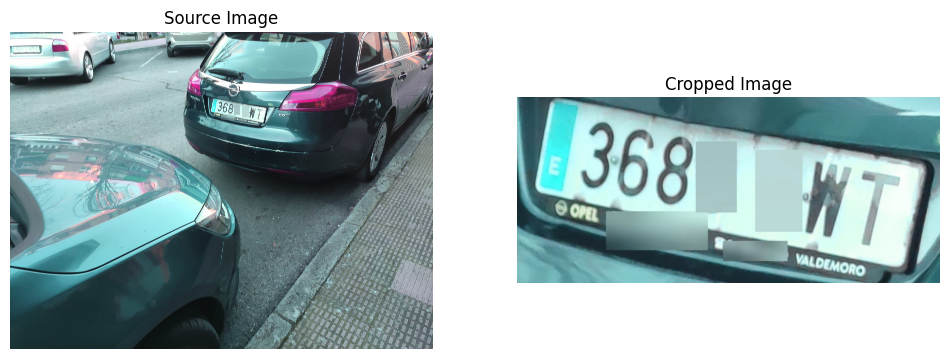

{'Text': '003 4 DP', 'Probability': 0.28774433495312435}


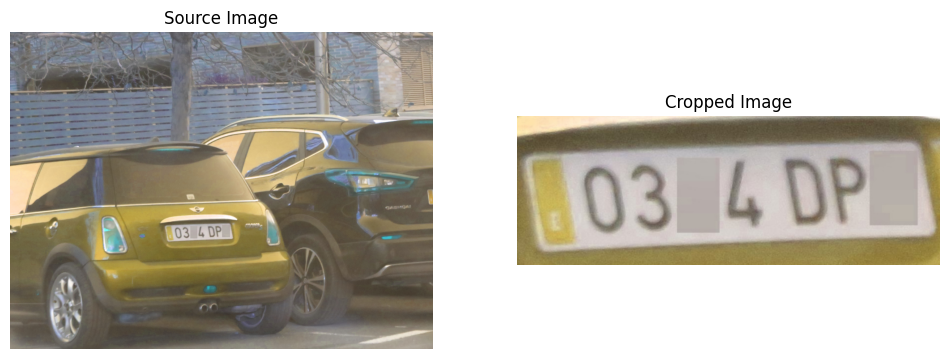

{'Text': '0', 'Probability': 0.7750235142360808}
{'Text': 'E', 'Probability': 0.5818423468745095}
{'Text': 'MW Mme', 'Probability': 0.5346290203238648}
{'Text': '3', 'Probability': 0.06507989340328013}


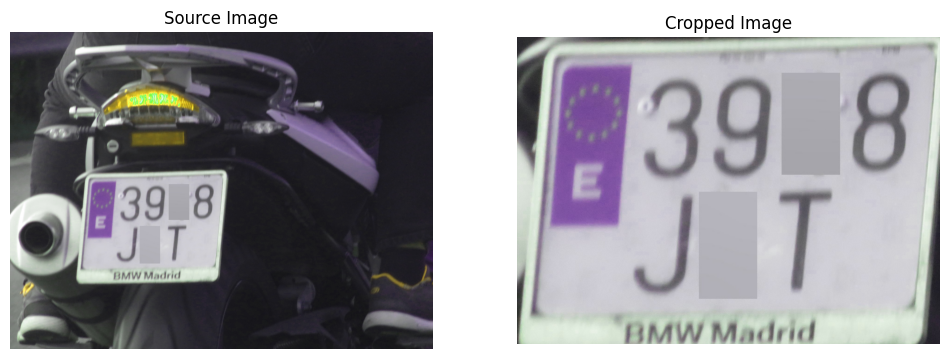

{'Text': '37', 'Probability': 0.9999992413568111}
{'Text': '5 C', 'Probability': 0.8210881602519251}
{'Text': 'Y', 'Probability': 0.8995362013968453}


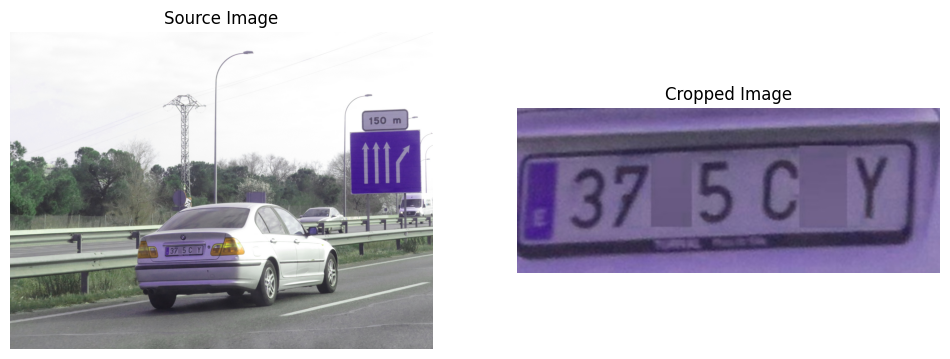

In [8]:
import random

first_dataset = source_dataset_location
second_dataset = scale_dataset_location

# start_index = 0
start_index = random.randint(0, len(os.listdir(second_dataset)))

for img_file in os.listdir(second_dataset)[start_index:start_index+10]:
    if img_file.endswith('jpg'):
        cropped_img_path = os.path.join(second_dataset, img_file)
        source_img_path = os.path.join(first_dataset, img_file[6:])
        results_path = os.path.join(results_dir, img_file[:-3]+'json')

        cropped_img = cv2.imread(cropped_img_path)
        source_img = cv2.imread(source_img_path)
        cropped_img_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
        source_img_rgb = cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB)
        
        with open(results_path, 'r') as f:
            results = json.load(f)
            for result in results:
                print(result)
        
        # Plot images and results
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(source_img_rgb)
        axes[0].set_title('Source Image')
        axes[0].axis('off')
        
        axes[1].imshow(cropped_img_rgb)
        axes[1].set_title('Cropped Image')
        axes[1].axis('off')
        
        plt.show()

In [9]:
df_true_location = f'{dataset_location}/output.csv'
df_true = pd.read_csv(df_true_location)
df_true['picture_name'] = df_true['picture_name'].apply(lambda x: 'plate_'+x)
df_true.set_index('picture_name', inplace=True)
df_true.head()

,text
picture_name,
plate_00808.jpg,046TS
plate_01433.jpg,912FB
plate_01063.jpg,044FF
plate_01576.jpg,M496T
plate_00263.jpg,155DW


In [10]:
df_pred_location = f'{output_location}/pred.csv'
plate_numbers = []
plate_strings = []

threshold = 0.6

for ocr_file in os.listdir(results_dir):
    with open(os.path.join(results_dir, ocr_file), 'r') as f:
        plt_str = ''
        results = json.load(f)
        for result in results:
            if float(result['Probability']) > threshold:
                plt_str += result['Text']
        plt_str = plt_str.replace(" ", "").upper()
        plate_strings.append(plt_str)
        plate_numbers.append(ocr_file.split('.')[0]+'.jpg')

df_pred = pd.DataFrame({'picture_name':plate_numbers, 'text':plate_strings})
df_pred.to_csv(df_pred_location)
df_pred.set_index('picture_name', inplace=True)
df_pred.head()

,text
picture_name,
plate_01772.jpg,
plate_00694.jpg,"238BG"""
plate_00978.jpg,1947MP
plate_01461.jpg,LLY881
plate_00857.jpg,0659


In [11]:
import pandas as pd
from difflib import SequenceMatcher
from sklearn.metrics import f1_score, precision_score, recall_score

# Merging dataframes on 'picture_name' index to only evaluate overlapping entries
df_merged = df_true.join(df_pred, lsuffix='_true', rsuffix='_pred', how='inner')

# 1. Accuracy (Exact Match)
exact_matches = (df_merged['text_true'] == df_merged['text_pred']).sum()
accuracy = exact_matches / len(df_merged)

# 2. Levenshtein Distance (Edit Distance) - Using SequenceMatcher
def levenshtein_ratio(str1, str2):
    return SequenceMatcher(None, str1, str2).ratio()

df_merged['levenshtein_ratio'] = df_merged.apply(lambda row: levenshtein_ratio(row['text_true'], row['text_pred']), axis=1)
average_levenshtein_ratio = df_merged['levenshtein_ratio'].mean()

# 3. Character-Level Precision, Recall, F1 Score
def calculate_char_level_scores(true_text, pred_text):
    # Creating sets of characters for precision, recall, F1
    true_chars = set(true_text)
    pred_chars = set(pred_text)
    
    true_positive = len(true_chars & pred_chars)
    precision = true_positive / len(pred_chars) if pred_chars else 0
    recall = true_positive / len(true_chars) if true_chars else 0
    f1 = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0
    return precision, recall, f1

# Calculate character-level scores for each entry
df_merged[['char_precision', 'char_recall', 'char_f1']] = df_merged.apply(
    lambda row: pd.Series(calculate_char_level_scores(row['text_true'], row['text_pred'])), axis=1
)

# Aggregate the results
average_precision = df_merged['char_precision'].mean()
average_recall = df_merged['char_recall'].mean()
average_f1_score = df_merged['char_f1'].mean()

# Output results
print(f"Accuracy (Exact Match): {accuracy:.2f}")
print(f"Average Levenshtein Ratio: {average_levenshtein_ratio:.2f}")
print(f"Character-Level Precision: {average_precision:.2f}")
print(f"Character-Level Recall: {average_recall:.2f}")
print(f"Character-Level F1 Score: {average_f1_score:.2f}")

df_merged_loaction = f'{output_location}/merged.csv'
df_merged.to_csv(df_merged_loaction)


Accuracy (Exact Match): 0.08
Average Levenshtein Ratio: 0.45
Character-Level Precision: 0.60
Character-Level Recall: 0.46
Character-Level F1 Score: 0.50
